In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV,  cross_val_predict
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [39]:
data = pd.read_csv('hospital_readmissions.csv')

In [40]:
data['severity'] = data['time_in_hospital'] * (data['n_lab_procedures'] + 32 * data['n_procedures'])

In [41]:
data['log_time_in_hospital'] = np.log1p(data['time_in_hospital'])
data['log_n_procedures'] = np.log1p(data['n_procedures'])
data['log_n_inpatient'] = np.log1p(data['n_inpatient'])
data['log_severity'] = np.log1p(data['severity'])

data = data.drop(['time_in_hospital', 'n_procedures', 'n_inpatient', 'severity'], axis=1)

In [42]:
# One-hot encoding categorical variables
data_encoded = pd.get_dummies(data, columns=[
    'age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med'
], drop_first=True)
data_encoded

,n_lab_procedures,n_medications,n_outpatient,n_emergency,readmitted,log_time_in_hospital,log_n_procedures,log_n_inpatient,log_severity,age_[50-60),...,diag_3_Missing,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory,glucose_test_no,glucose_test_normal,A1Ctest_no,A1Ctest_normal,change_yes,diabetes_med_yes
0,72,18,2,0,no,2.197225,0.693147,0.000000,6.725034,0,...,0,0,1,0,1,0,1,0,0,1
1,34,13,0,0,no,1.386294,1.098612,0.000000,5.686975,0,...,0,0,1,0,1,0,1,0,0,1
2,45,18,0,0,yes,1.791759,0.000000,0.000000,5.420535,1,...,0,0,0,0,1,0,1,0,1,1
3,36,12,1,0,yes,1.098612,0.000000,0.000000,4.290459,0,...,0,0,0,0,1,0,1,0,1,1
4,42,7,0,0,no,0.693147,0.000000,0.000000,3.761200,0,...,0,0,0,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,77,30,0,0,yes,2.708050,0.693147,0.000000,7.331060,0,...,0,0,0,0,1,0,0,1,0,0
24996,66,24,0,0,yes,1.098612,0.000000,0.000000,4.890349,0,...,0,0,1,0,1,0,0,0,1,1
24997,12,6,0,0,yes,1.791759,0.000000,0.693147,4.110874,0,...,0,0,1,0,0,1,1,0,0,0
24998,61,15,0,0,no,1.098612,1.386294,0.000000,5.752573,0,...,0,0,1,0,1,0,1,0,1,1


In [43]:
# Mapping the target column "readmitted" to binary values
data_encoded['readmitted'] = data_encoded['readmitted'].map({'no': 0, 'yes': 1})

In [44]:
# Splitting the dataset into features (X) and target (y)
X = data_encoded.drop('readmitted', axis=1)
y = data_encoded['readmitted']

In [45]:
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
cv = StratifiedKFold(n_splits=10)
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up hyperparameter grid for GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 10),
    'class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
}

# Initialize logistic regression model
log_reg = LogisticRegression(solver='liblinear', max_iter=1000)

# Run GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, scoring=scorer, cv=cv, n_jobs=-1, refit=True)
grid_search.fit(X, y)

# Collect best parameters and best scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display top ranks based on mean test score
ranked_results = cv_results[['rank_test_score', 'mean_test_score', 'param_class_weight', 'param_penalty', 'param_C']]
ranked_results = ranked_results.sort_values(by='rank_test_score').head()

# Display train and validation AUC for each fold in cross-validation
train_auc_scores, val_auc_scores = [], []
for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    model = LogisticRegression(**best_params, solver='liblinear', max_iter=1000)
    model.fit(X_train, y_train)
    train_auc_scores.append(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    val_auc_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))

auc_table = pd.DataFrame({
    'Train AUC (CV)': train_auc_scores,
    'Validation AUC (CV)': val_auc_scores
})
auc_table.loc['Mean'] = auc_table.mean()





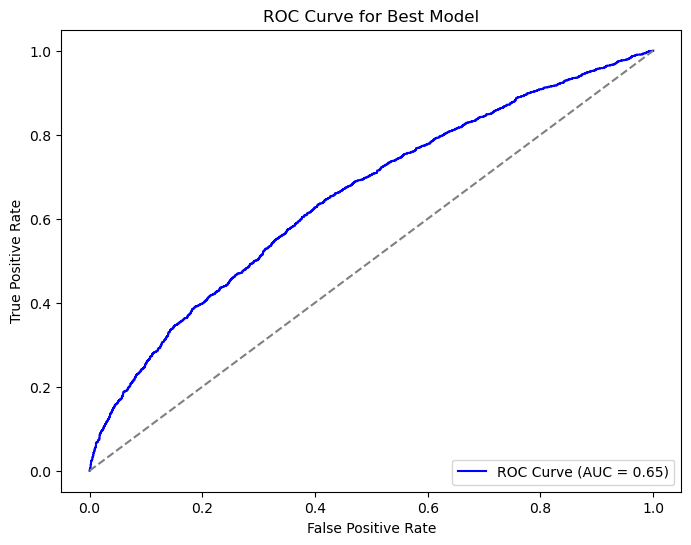

In [47]:
best_model = grid_search.best_estimator_

# Get the predicted probabilities for the positive class (class 1)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Model')
plt.legend(loc="lower right")
plt.show()

In [49]:
coefficients = best_model.coef_[0]
intercept = best_model.intercept_[0]
pred_probs = best_model.predict_proba(X_train)[:, 1]

# Calculate the diagonal matrix of weights
V = np.diag(pred_probs * (1 - pred_probs))

# Calculate the Hessian approximation
X_train_with_intercept = np.hstack([np.ones((X_train.shape[0], 1)), X_train])  # Add intercept
Hessian_inv = np.linalg.inv(X_train_with_intercept.T @ V @ X_train_with_intercept)

# Extract standard errors (square root of diagonal elements of Hessian_inv)
standard_errors = np.sqrt(np.diag(Hessian_inv))

z_statistics = coefficients / standard_errors[1:]  # [1:] to exclude intercept error

p_values = 2 * (1 - norm.cdf(np.abs(z_statistics)))

# Prepare feature names, adding intercept
feature_names = ['Intercept'] + list(X_train.columns)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': np.insert(coefficients, 0, intercept),  # insert intercept at start
    'Standard Error': standard_errors,
    'Z-Statistic': np.insert(z_statistics, 0, np.nan),  # no z-stat for intercept
    'P-Value': np.insert(p_values, 0, np.nan)  # no p-value for intercept
})
# Format p-values without scientific notation
results_df['P-Value'] = results_df['P-Value'].apply(lambda x: f"{x:.10f}")


results_df

,Feature,Coefficient,Standard Error,Z-Statistic,P-Value
0,Intercept,0.531453,0.186557,NaN,nan
1,n_lab_procedures,0.001069,0.001432,0.746666,0.4552654736
2,n_medications,0.000833,0.002759,0.301827,0.7627841291
3,n_outpatient,0.126060,0.021678,5.815185,0.0000000061
4,n_emergency,0.235657,0.042998,5.480609,0.0000000424
5,log_time_in_hospital,0.123700,0.067399,1.835343,0.0664548644
6,log_n_procedures,-0.123428,0.052622,-2.345536,0.0189997201
7,log_n_inpatient,0.818472,0.044855,18.247248,0.0000000000
8,log_severity,0.026010,0.044190,0.588593,0.5561340445
9,age_[50-60),0.000000,0.065099,0.000000,1.0000000000


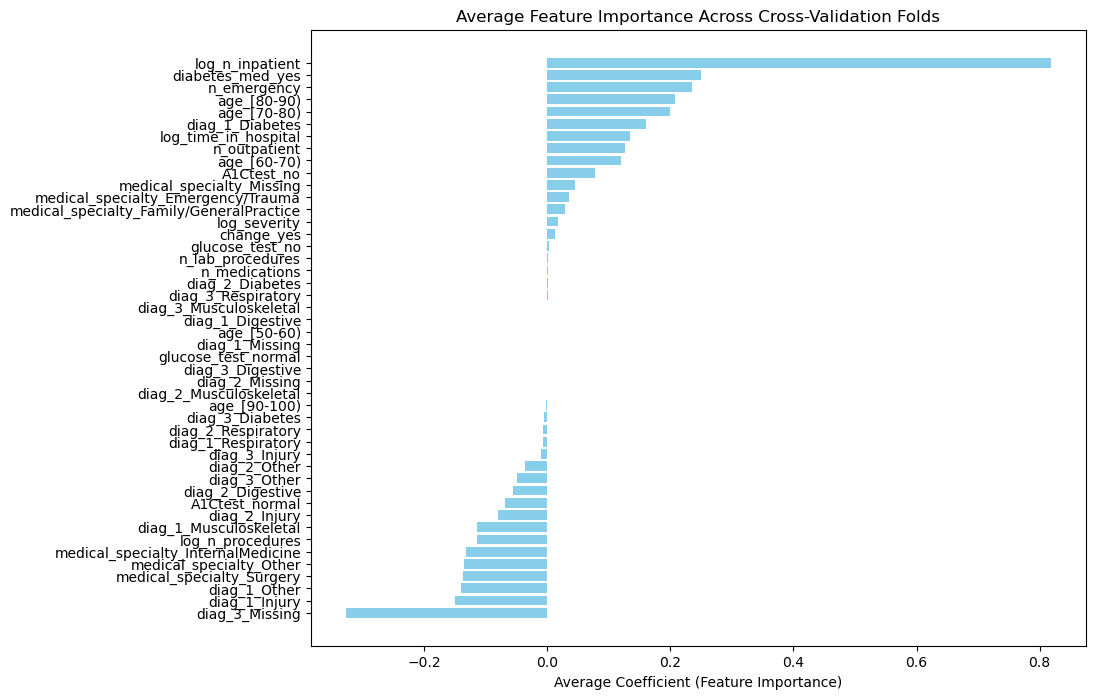

In [50]:
# Calculate feature importances (average coefficients across folds)
feature_importances = []
for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train = y.iloc[train_idx]
    model = LogisticRegression(**best_params, solver='liblinear', max_iter=1000)
    model.fit(X_train, y_train)
    feature_importances.append(model.coef_[0])

avg_feature_importance = np.mean(feature_importances, axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Average Coefficient (Feature Importance)': avg_feature_importance
}).sort_values(by='Average Coefficient (Feature Importance)', ascending=False)

# Plot average feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Average Coefficient (Feature Importance)'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Average Coefficient (Feature Importance)")
plt.title("Average Feature Importance Across Cross-Validation Folds")
plt.show()



In [51]:
# Output tables
logreg_regu = pd.DataFrame(ranked_results)
print("Ranked Results Based on Mean Test Score:")
logreg_regu



Ranked Results Based on Mean Test Score:


,rank_test_score,mean_test_score,param_class_weight,param_penalty,param_C
28,1,0.647894,"{0: 1, 1: 5}",l1,0.046416
36,2,0.647549,"{0: 1, 1: 5}",l1,0.359381
30,3,0.647538,"{0: 1, 1: 10}",l1,0.046416
27,4,0.647428,balanced,l2,0.046416
34,5,0.647419,balanced,l1,0.359381


In [52]:
print("\nTrain and Validation AUC Scores Across Cross-Validation Folds:")
pd.DataFrame(auc_table)


Train and Validation AUC Scores Across Cross-Validation Folds:


,Train AUC (CV),Validation AUC (CV)
0,0.652160,0.635475
1,0.649595,0.660703
2,0.650740,0.656012
3,0.648923,0.666386
4,0.652749,0.633288
5,0.651980,0.639189
6,0.649318,0.663384
7,0.650022,0.657707
8,0.652834,0.633606
9,0.652678,0.630321
